### Modelo de Previsão do Percentual de Cumprimento de Metas

### Tarefa 

Crie um modelo capaz de prever o **percentual de cumprimento da meta** ao fim do ano para um determinado funcionário. Descreva cada detalhe considerado para o modelo, como qual foia estratégia de separação entre teste e validação e métricas de performance.

### Considerações

Todo processo de resolução de problemas de data-science envolvem questões não muito claras e dados longe de serem totalmente interpretaveis, dessa forma para resolver a tarefa proposta é necessário esclarecer alguns pontos dela usando algumas considerações que surgiram neste projeto.


##### Sobre os dados...

**meta**: em geral os funcionários tem 5 KPIs que são alocados a ele, mas isso não significa que eles são todos usados, talvez seja padrão do software de gestão utilizado ter esses KPIs para o cargo/area do funcionário e dentro do escopo do trabalho dele, os seus gestores dão um 'flag' nos KPIs que serão utilizados para compor os resultados deles, esse 'flag' na base de dados disponibilizada é dada pela coluna 'Status Meta' quando aquela linha possui o valor 'Monitoramento Aprovado', dessa forma é possível chegar ao entendimento que uma meta se refere a um KPI que será monitorado para aquele funcionário.

**percentual cumprimento da meta ao fim do ano**: cada funcionário pode ter mais de uma meta e de forma geral quando se pensa no percentual de cumprimento de cada meta, não faz muito sentido agregar essas metas concomitantes pois cada KPI apresenta carrega suas caracteristicas próprias, de modo que para ter um modelo que tenha como target o percentual de cumprimento da meta se fará uma previsão para cada uma das metas do funcionário separadamente.

**ao fim do ano**: como os dados disponíveis só engloba 10 meses e sendo que boa parte dos funcionários não está presente em todos os meses, foi considerado que faz mais sentido criar um modelo que utilize apenas as informações iniciais do funcionário, no caso apenas suas informações do primeiro mês, e que o percentual de metas cumpridas de cada funcionário no periodo que ele aparece na base é uma boa generalização do resultado dele no ano.

##### Sobre o modelo e as métricas...

Como o problema busca generalizar uma variável continua que representa uma proporção (das metas), mesmo que essa se mantenha entre 0 e 1 ele é um problema de regressão.

**Modelo** Como as features a serem utilizadas são todas categoricas serão testados modelos que lidam bem com esse tipo de distribuição discreta.

**Metricas** Sendo um problema de regressão, a métrica de Erro Médio Quadrado é uma opção adequada pois tratará de tentar manter os valores o mais próximo dos reais sendo que não temos um target com outliers ou distribuição de calda longa, o que seria um caso para utilizar alguma outra métrica. 

**Validação** Uma média das validações cruzadas em 5 folds do dataset.

### Premissas

Como na base de dados bruta fornecida tem inconsistências e também não é muito claro a definição de meta comprida se faz necessário criar algumas premissas sobre a lógica do negócio e criar o pipelino do modelo a partir delas.


    1. Uma meta é um KPI com Monitoramento Aprovado.
    2. Metas são referentes a apenas aquele mês.
    3. O percentual de cumprimento de uma meta para um mês é representado pela coluna Atingido Mês (ating_mes).
    4. O percentual de cumprimento da meta (target) um funcionário em certo periodo é calculado como:
         target = (soma_metas / quantidade_de_metas) / 100
         sendo que:
             quantidade_de_metas é o total de metas do período
             soma_metas é a soma do valor dessas metas
             
             
### Conclusões







-----------------









### 1. Preparação

In [111]:
import pandas as pd
import numpy as np
import warnings

# Bibliotecas de validação
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Bibliotecas de modelos
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Ignorar warnings do sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

In [113]:
# Lendo base
df = pd.read_pickle('../data/processed/ambev-final-dataset.pkl')
print('Base com {} linhas e {} colunas.'.format(*df.shape))
y = df.target
X = df.drop('target', axis=1)

Base com 6124 linhas e 21 colunas.


### 2. Seleção do Modelo

In [178]:
# Baseline modelo média do target
y_pred = pd.Series([y.mean() for v in y])
# RMSE do modelo média
((y - y_pred) ** 2).mean() ** .5

0.33329786543845774

In [98]:
# Modelos a serem testados
models = [
    ('LGBM', LGBMRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('RF', RandomForestRegressor()),]

In [99]:
# Computa as validações cruzadas de todos os modelos inputados
folds = 5

for name, model in models:
    # calcula as cvs
    cv_results = cross_val_score(model, X, y, cv=folds, scoring='neg_mean_squared_error')

    # salva/printa os resultados
    print('{}\t:{}\t(std: {})'.format(name, -1 * cv_results.mean(), cv_results.std()))

LGBM	:0.07889606932038792	(std: 0.002703141021047404)
KNN	:0.09325346020165831	(std: 0.0030134205464081784)
RF	:0.08462386733657794	(std: 0.0025340630747178643)


In [114]:
# Modelo escolhido
model = LGBMRegressor()

### 3. Tuning de Parametros e CV Final

In [120]:
# Função para reportar os modelos com melhores parametros
def report(results, top=3):
    for i in range(1, top + 1):
        models = np.flatnonzero(results['rank_test_score'] == i)
        for model in models:
            print("Modelo: {0}".format(i))
            print("RMSE: {0:.3f} (-mse: {1:.3f}) (std: {1:.3f})".format(
                  (-1 * results['mean_test_score'][model]) ** 0.5,
                  results['mean_test_score'][model],
                  results['std_test_score'][model]))
            print("Parametros: {0}\n".format(results['params'][model]))


# Parametros a serem explorados
param_dist = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [-1, -2, -4],
    'min_child_samples': [20, 30, 50, 70],
    'min_child_weight': [0.001, 0.01, 0.05],
    'min_split_gain': [0.0, 0.01, 0.1],
    'n_estimators': [50, 100, 150, 200],
    'num_leaves': [20, 31, 40, 60],
    'random_state': [100],
    'subsample': [1.0, 0.9, 0.8]}

# Tuning de parametros com busca aleatória e validação cruzada
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=30, cv=5, scoring='neg_mean_squared_error')
# Rodando a busca
random_search.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [-1, -2, -4], 'min_child_samples': [20, 30, 50, 70], 'min_child_weight': [0.001, 0.01, 0.05], 'min_split_gain': [0.0, 0.01, 0.1], 'n_estimators': [50, 100, 150, 200], 'num_leaves': [20, 31, 40, 60], 'random_state': [100], 'subsample': [1.0, 0.9, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scor

In [121]:
report(random_search.cv_results_)

Modelo: 1
RMSE: 0.279 (-mse: -0.078) (std: -0.078)
Parametros: {'subsample': 1.0, 'random_state': 100, 'num_leaves': 31, 'n_estimators': 200, 'min_split_gain': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.1}

Modelo: 2
RMSE: 0.279 (-mse: -0.078) (std: -0.078)
Parametros: {'subsample': 1.0, 'random_state': 100, 'num_leaves': 60, 'n_estimators': 100, 'min_split_gain': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 20, 'max_depth': -4, 'learning_rate': 0.05}

Modelo: 3
RMSE: 0.279 (-mse: -0.078) (std: -0.078)
Parametros: {'subsample': 0.9, 'random_state': 100, 'num_leaves': 40, 'n_estimators': 200, 'min_split_gain': 0.01, 'min_child_weight': 0.05, 'min_child_samples': 20, 'max_depth': -4, 'learning_rate': 0.1}



In [122]:
# Modelo com os parametros tunados
model = random_search.best_estimator_

In [155]:
# Parametros escolhidos
print(*model.get_params().items(), sep='\n')

('boosting_type', 'gbdt')
('class_weight', None)
('colsample_bytree', 1.0)
('importance_type', 'split')
('learning_rate', 0.1)
('max_depth', -1)
('min_child_samples', 50)
('min_child_weight', 0.01)
('min_split_gain', 0.0)
('n_estimators', 200)
('n_jobs', -1)
('num_leaves', 31)
('objective', None)
('random_state', 100)
('reg_alpha', 0.0)
('reg_lambda', 0.0)
('silent', True)
('subsample', 1.0)
('subsample_for_bin', 200000)
('subsample_freq', 0)


### 4. Importância das Features

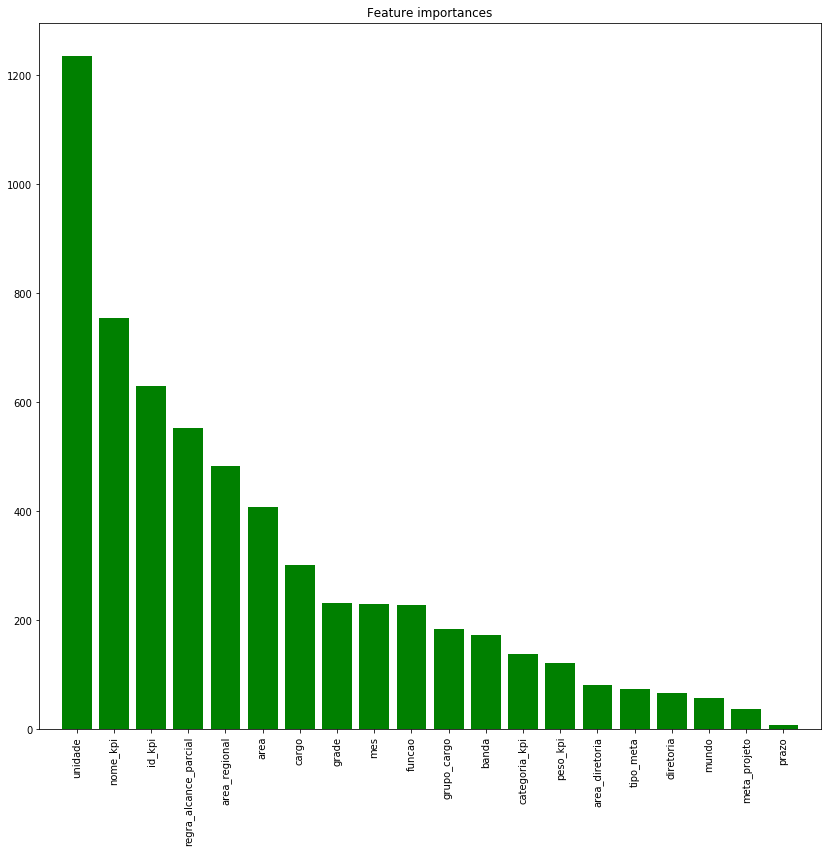

In [124]:
import matplotlib.pyplot as plt
model = model.fit(X, y)
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()